# A Simple Diffusion Model 


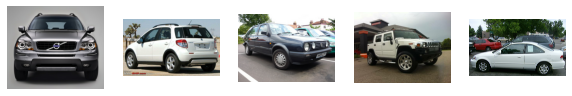

In [30]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math

dataset, dataset_info = tfds.load('cars196', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']


# Plot 5 images from the dataset
plt.figure(figsize=(10,10))
for i, example in enumerate(train_dataset.take(5)):

    image = example[0]
    plt.subplot(1, 5, i+1)
    plt.imshow(np.squeeze(image), cmap='gray')
    plt.axis("off")

plt.show()

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect. 

## Step 1: Forward process




We first need to build the inputs for our model, which are more and more noisy images. 

Remember: 

$$
q(x_t | x_0) = N(x_t; \sqrt{\bar{\alpha}_t} x_0, (1- \bar{\alpha}_t) I)$$


<br>

where $\alpha_t := 1 - \beta_t$ and $\bar{\alpha}_t := \Pi_{s=1}^{t} \alpha_s$.

<br> <br>
We can compute $\mathbf{x}_t$ by sampling $\epsilon \sim N(\mathbf{0}, \mathbf{I})$ and then setting $x_t = \sqrt{\bar{\alpha}_t} x_{0} +  \sqrt{1 - \bar{\alpha}_t}\epsilon$. 





In [31]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
  return np.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
  """
  Returns a specific index t of a passed list of values vals
  while considering the batch dimension.
  """
  batch_size = tf.shape(t)[0] # 1
  out = tf.gather(vals, t, axis=-1)
  shape = [batch_size] + [1] * (len(x_shape) - 1)
  out = tf.reshape(out, shape)
  out =  tf.cast(out, tf.float32)
  return out

def forward_diffusion_sample(x_0, t):
  """
  Takes an image and a timestep as input and
  returns the noisy version of it
  """
  noise = tf.random.normal(x_0.shape, dtype=tf.dtypes.float32,)

  sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

  return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

#Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

#Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = tf.math.cumprod(alphas, axis=0)

alphas_cumprod_prev = tf.pad(alphas_cumprod[:-1], [[1, 0]])
sqrt_recip_alphas = tf.math.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = tf.math.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = tf.math.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [32]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    # Load the train and test datasets
    cars196_train = tfds.load('cars196', split='train')
    cars196_test = tfds.load('cars196', split='test')


    # Combine the train and test sets
    cars196 = cars196_train.concatenate(cars196_test)

    # Define the data preprocessing pipeline
    def preprocess(example):
        image = example['image']
        image = tf.image.resize(image, [64, 64])
        image = tf.image.random_flip_left_right(image)
        image = tf.cast(image, tf.float32)
        image = (image / 127.5) - 1
        return image

    # Apply the preprocessing pipeline to the dataset
    cars196 = cars196.map(preprocess)

    # Convert the dataset to a tensor
    # cars196 = cars196.prefetch(tf.data.AUTOTUNE)

    return cars196

data = load_transformed_dataset()

def show_tensor_image(image):
  image = (image + 1) / 2
  image = image * 255
  image = image.numpy().astype(np.uint8)
  if len(image.shape) == 4:
        image = image[0, :, :, :] 
  plt.imshow(image)
  plt.axis('off')

data = data.shuffle(buffer_size=1024).batch(128, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

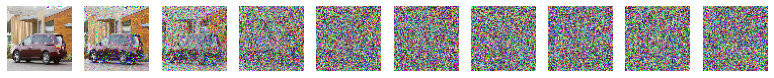

In [33]:
image = next(iter(data))

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = tf.constant([idx], dtype=tf.int64)
    plt.subplot(1, num_images+1, (idx/stepsize) + 1)

    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Step 2: The backward process = U-Net



Here, we use a simple form of a UNet for to predict the noise in the image

Remember, the input is a noisy image, the ouput the noise in the image. The timestep is encoded by the transformer Sinusoidal Embedding.

The below architecture is very simple. You can improve the architecture by adding your own residual connections, normalizations, activation functions or attention layers.


In [34]:
import tensorflow as tf
import math

class Block(tf.keras.Model):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = tf.keras.layers.Dense(out_ch, activation='relu')
        self.conv1 = tf.keras.layers.Conv2D(out_ch, (3, 3), padding='same')
        if up:
            self.transform = tf.keras.layers.Conv2DTranspose(out_ch, (4, 4), strides=2, padding='same')
        else:
            self.transform = tf.keras.layers.Conv2D(out_ch, (4, 4), strides=2, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(out_ch, (3, 3), padding='same')
        self.bnorm1 = tf.keras.layers.BatchNormalization()
        self.bnorm2 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, x, t):

        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[:,tf.newaxis, tf.newaxis, :]

        h = tf.keras.layers.Add()([h, time_emb])
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)


class SinusoidalPositionEmbeddings(tf.keras.Model):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def call(self, time):
 
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = tf.exp(tf.range(half_dim, dtype=tf.float32) * -embeddings)
        time = tf.cast(time, tf.float32)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = tf.concat((tf.sin(embeddings), tf.cos(embeddings)), axis=-1)
        return embeddings


class SimpleUnet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = [64, 128, 256, 512, 1024]
        up_channels = [1024, 512, 256, 128, 64]
        out_dim = 1 
        time_emb_dim = 32

        self.time_mlp = tf.keras.Sequential([
            SinusoidalPositionEmbeddings(time_emb_dim),
            tf.keras.layers.Dense(time_emb_dim),
            tf.keras.layers.ReLU()
        ])
        
        self.conv0 = tf.keras.layers.Conv2D(down_channels[0], 3, padding='same')

        # Downsample
        self.downs = [Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels) - 1)]
        # Upsample
        self.ups = [Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)]

        self.model_output = tf.keras.layers.Conv2D(3, out_dim)

    def call(self, x, timestep):

        t = self.time_mlp(timestep)

        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Concatenate residual x to the feature map
            x = tf.concat([x, residual_x], axis=-1)        
            x = up(x, t)
        # Output
        return self.model_output(x)


In [35]:
model = SimpleUnet()

### Defining the loss function



From class, we learnt that after some maths we end up with a very simple loss function:


$$
L_t = ||\epsilon - \epsilon_\theta(x_t, t)||^2. 
$$


You can also try the L1 loss and see if it performs well.


In [36]:

def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t)
    noise_pred = model(x_noisy, t)

    return tf.math.reduce_mean(tf.abs(noise - noise_pred))
    # return tf.keras.losses.mean_squared_error(noise, pred_noise)

## Step 3: Training and Sampling

### Sampling

![](https://drive.google.com/uc?export=view&id=1cz8qQAM8bLSFRBuROnHbMPUawd9bM8V4)

In [37]:
def sample_timestep(x, t):

    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)


    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        
        
        noise = tf.random.normal(x.shape, dtype=tf.dtypes.float32)

        return model_mean + tf.math.sqrt(posterior_variance_t) * noise 


def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = tf.random.normal((1, img_size, img_size, 3))
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(T-1, -1, -1):
        t = tf.constant(i, shape=(1,), dtype=tf.int32)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i//stepsize+1)
            show_tensor_image(img)
    plt.show()

### Training

![](https://drive.google.com/uc?export=view&id=1d01Ose2Agh1UxjwviOtEfRVm8WUxL842)

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
epochs = 100 

for epoch in range(epochs):
  for step, batch in enumerate(data):
    t = tf.random.uniform(shape=(BATCH_SIZE,), minval=0, maxval=T, dtype=tf.int32)
    with tf.GradientTape() as tape:
        loss = get_loss(model, batch, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.numpy()} ")
      sample_plot_image()